<a href="https://colab.research.google.com/github/ShangWeiKuo/106-2-R-project/blob/master/Python/Classification/Multiclass/Wafer/Wafer_classification_KFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-plot

In [2]:
# loading libraries
import numpy as np # linear algebra
from numpy import argmax
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scikitplot as skplt
%matplotlib inline 

from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from keras.utils.np_utils import to_categorical
from keras import layers, Input, models
from keras.models import Model, Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report

import cv2
from skimage import measure
from scipy import stats

import os
# set current working directory
path="/content/drive/MyDrive/wafer/"
os.chdir(path)

print(os.listdir(path))

import warnings
warnings.filterwarnings("ignore")

['LSWMD.pkl', 'wafer.zip', 'Untitled1.ipynb', 'wafer-defect-classification-by-deep-learning.ipynb', 'Wafer detection.ipynb', 'Wafer anomaly detection.ipynb', 'Wafer anomaly detection_AutoEncoder.ipynb', 'Wafer classification_Densenet201.ipynb', 'Wafer classification_KFold.ipynb', 'wafer_detection_densenet_model.h5']


In [3]:
df=pd.read_pickle("LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [4]:
df['waferIndex']
df = df.drop(['waferIndex'], axis = 1)

In [5]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
390167,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4423.0,lot23424,[],[],"(74, 76)"
599248,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot37638,[],[],"(49, 39)"
233033,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7810.0,lot14586,[],[],"(89, 112)"
349869,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5532.0,lot20884,[],[],"(60, 119)"
596601,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot37391,[],[],"(49, 39)"


In [6]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [7]:
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_withpattern = df_withpattern.drop(columns=['dieSize', 'lotName'])

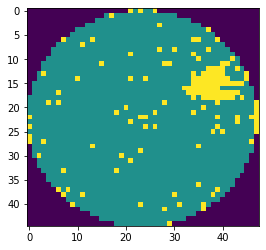

In [8]:
plt.imshow(df_withpattern.waferMap[0])
plt.show()

In [32]:
train_set = df_withpattern[df_withpattern['trianTestLabel'] == 'Training']
X_train = train_set['waferMap'].values
y_train = np.array(train_set['failureNum']).astype('float32')
y_train = to_categorical(y_train, num_classes=8)

In [33]:
X_train = train_set['waferMap']
y_train = np.array(train_set['failureNum']).astype('float32')
y_train = to_categorical(y_train, num_classes=8)

In [34]:
X_train = np.array([cv2.resize(img, dsize=(26,26)) for img in X_train])

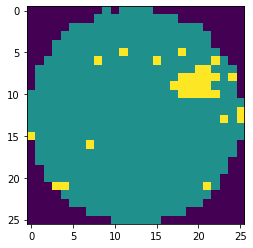

In [35]:
plt.imshow(X_train[0])
plt.show()

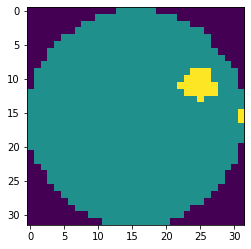

In [13]:
plt.imshow(cv2.medianBlur(X_train[0], 3))
plt.show()

In [36]:
X_train = X_train.reshape((-1, 26, 26, 1))

In [37]:
new_X_train = np.zeros((len(X_train), 26, 26, 3))

for w in range(len(X_train)):
    for i in range(26):
        for j in range(26):
            new_X_train[w, i, j, int(X_train[w, i, j])] = 1

In [38]:
# Conversion to float
new_X_train = new_X_train.astype('float32')

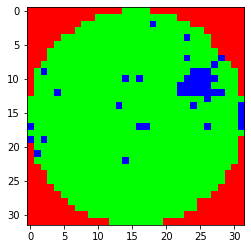

In [17]:
plt.imshow(new_X_train[0])
plt.show()

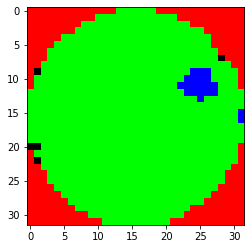

In [18]:
plt.imshow(cv2.medianBlur(new_X_train[0], 3))
plt.show()

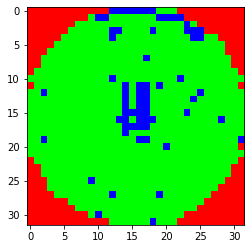

In [19]:
plt.imshow(new_X_train[train_set['failureNum']==0][0])
plt.show()

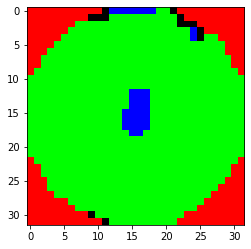

In [20]:
plt.imshow(cv2.medianBlur(new_X_train[train_set['failureNum']==0][0], 3))
plt.show()

In [39]:
X_train_copy = [ ]

for i in range(new_X_train.shape[0]):
  img = cv2.medianBlur(new_X_train[i], 3)
  X_train_copy.append(img)

X_train_copy = np.array(X_train_copy)

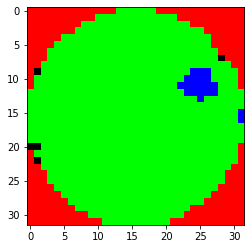

In [22]:
plt.imshow(X_train_copy[0])
plt.show()

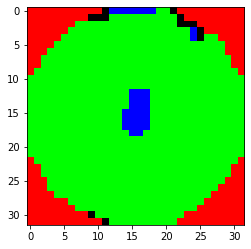

In [23]:
plt.imshow(X_train_copy[train_set['failureNum']==0][0])
plt.show()

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_train_copy, y_train, test_size=0.2, random_state=2021)

In [41]:
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(8, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [42]:
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2021) 
results = cross_val_score(model, X_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/30
10/10 - 117s - loss: 2.9140 - accuracy: 0.3672
Epoch 2/30
10/10 - 116s - loss: 0.9535 - accuracy: 0.7041
Epoch 3/30
10/10 - 116s - loss: 0.5968 - accuracy: 0.7982
Epoch 4/30
10/10 - 116s - loss: 0.4280 - accuracy: 0.8495
Epoch 5/30
10/10 - 115s - loss: 0.3136 - accuracy: 0.8880
Epoch 6/30
10/10 - 115s - loss: 0.2592 - accuracy: 0.9046
Epoch 7/30
10/10 - 116s - loss: 0.2225 - accuracy: 0.9181
Epoch 8/30
10/10 - 115s - loss: 0.2019 - accuracy: 0.9267
Epoch 9/30
10/10 - 115s - loss: 0.1764 - accuracy: 0.9345
Epoch 10/30
10/10 - 116s - loss: 0.1687 - accuracy: 0.9377
Epoch 11/30
10/10 - 116s - loss: 0.1533 - accuracy: 0.9422
Epoch 12/30
10/10 - 117s - loss: 0.1458 - accuracy: 0.9437
Epoch 13/30
10/10 - 116s - loss: 0.1359 - accuracy: 0.9494
Epoch 14/30
10/10 - 116s - loss: 0.1268 - accuracy: 0.9528
Epoch 15/30
10/10 - 116s - loss: 0.1233 - accuracy: 0.9546
Epoch 16/30
10/10 - 116s - loss: 0.1096 - accuracy: 0.9597
Epoch 17/30
10/10 - 117s - loss: 0.1042 - accuracy: 0.9606
Epoch 

In [43]:
model = create_model()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
es = EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=10)
checkpoint = ModelCheckpoint('wafer_detection_densenet_model.h5', verbose=1, save_best_only=True)

History = model.fit(X_train, y_train, 
          epochs=50, 
          batch_size=26,
          verbose=2,
          callbacks=[annealer, checkpoint],
          validation_data=(X_val, y_val), 
          workers=8)

Epoch 1/50
543/543 - 342s - loss: 0.4413 - accuracy: 0.8524 - val_loss: 0.2672 - val_accuracy: 0.9001

Epoch 00001: val_loss improved from inf to 0.26720, saving model to wafer_detection_densenet_model.h5
Epoch 2/50
543/543 - 344s - loss: 0.2116 - accuracy: 0.9226 - val_loss: 0.2431 - val_accuracy: 0.9152

Epoch 00002: val_loss improved from 0.26720 to 0.24313, saving model to wafer_detection_densenet_model.h5
Epoch 3/50
543/543 - 343s - loss: 0.1467 - accuracy: 0.9455 - val_loss: 0.2463 - val_accuracy: 0.9169

Epoch 00003: val_loss did not improve from 0.24313
Epoch 4/50
543/543 - 338s - loss: 0.1028 - accuracy: 0.9614 - val_loss: 0.2318 - val_accuracy: 0.9322

Epoch 00004: val_loss improved from 0.24313 to 0.23185, saving model to wafer_detection_densenet_model.h5
Epoch 5/50
543/543 - 339s - loss: 0.0875 - accuracy: 0.9670 - val_loss: 0.2910 - val_accuracy: 0.9296

Epoch 00005: val_loss did not improve from 0.23185
Epoch 6/50
543/543 - 345s - loss: 0.0648 - accuracy: 0.9764 - val_los

In [44]:
score = model.evaluate(X_val, y_val)
print('Testing Accuracy:',score[1])

111/111 [==============================] - 16s 145ms/step - loss: 0.8583 - accuracy: 0.9282
Testing Accuracy: 0.9282269477844238


In [45]:
predictions = model.predict(X_val)

In [46]:
predictions = np.argmax(predictions > 0.5, axis=1)

In [47]:
# from numpy import argmax
true = np.array([np.argmax(y, axis=None, out=None) for y in y_val])

In [49]:
# Confusion Matrix
print(classification_report(true, predictions))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       724
           1       0.79      0.84      0.81        73
           2       0.88      0.88      0.88       477
           3       0.97      0.99      0.98      1709
           4       0.82      0.74      0.78       310
           5       0.90      0.91      0.91       116
           6       0.56      0.46      0.51       105
           7       0.79      1.00      0.88        11

    accuracy                           0.93      3525
   macro avg       0.83      0.85      0.84      3525
weighted avg       0.92      0.93      0.93      3525



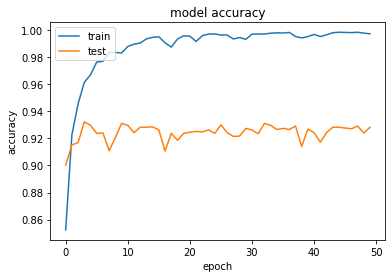

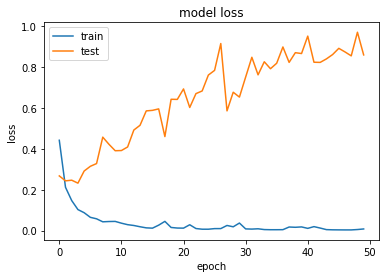

In [50]:
# accuracy plot 
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()